In [58]:
#Imports
import numpy as np
import pandas as pd
from scipy import linalg
from scipy import optimize
import sympy as sm
from scipy import interpolate

#Time
import time

#Add plot
import matplotlib.pyplot as plt # baseline modul
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3d figures
plt.style.use('seaborn-whitegrid') # whitegrid nice with 3d

# Linear regression

Consider the following **linear equation:**

$$y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \epsilon_i$$

Assume you have access to data of the **independent variables** ($x_{1,i}$, $x_{2,i}$) and the **dependent variable** ($y_i$) for $N$ individuals, where $i$ indexes individuals. The variable $\epsilon_i$ is a mean-zero **stochastic shock**.

Assume the **data generating process** is given by:

In [2]:
def DGP(N):
    
    # a. independent variables
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    
    # b. errors
    eps = np.random.normal(0,1,size=N)
    
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    
    # c. dependent variable
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    return x1, x2, y

**The data you have access to is:**

In [322]:
np.random.seed(2020)
x1,x2,y = DGP(10000)

**Question 1:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **ordinary least squares (OLS)** implemented with **matrix algebra** by

$$ \hat{\mathbf{\beta}} = (\mathbf{X}^{\prime}\mathbf{X})^{-1}\mathbf{X}^{\prime}\mathbf{y} $$

where $\mathbf{X}^{\prime}$ is the transpose of $\mathbf{X}$ and

$$\mathbf{y} = 
\pmatrix{ y_1 \cr y_2 \cr  \vdots \cr y_N 
}
, \quad \mathbf{X} = \pmatrix{
1 & x_{1,1} & x_{2,1} \cr 
1 & x_{1,2} & x_{2,2} \cr 
\vdots & \vdots \cr 
1 & x_{1,N} & x_{2,N} 
}$$

In [324]:
# We construct our X matrix from an column of 1's, x1 and x2
Y = np.array(y)
X1 = np.array(x1)
X2 = np.array(x2)
print(y.shape) #fjernes
print(X1.shape) #fjernes
print(X2.shape) #fjernes
x0 = np.ones(shape = y.shape)
print(x0.shape) #fjernes
x_0 = np.column_stack((x0,x1))
X = np.column_stack((x_0,x2))
print(X.shape) #fjernes
print(X)

(10000,)
(10000,)
(10000,)
(10000,)
(10000, 3)
[[ 1.         -1.76884571 -0.18279442]
 [ 1.          0.07555227  0.78062368]
 [ 1.         -1.1306297  -1.01220533]
 ...
 [ 1.          0.0370484  -1.44286811]
 [ 1.          1.70892684 -0.10668645]
 [ 1.          2.06128052  0.55908184]]


In [338]:
#Now that we have our X matrix we can calculate the estimated Beta coefficient
BETA = linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(Y)
print(BETA)
print('The Estimates for the beta coefficients is approximate correct to those of the model for y')
print(f'B_0={coeffs[0]:.1f}')
print(f'B_1={coeffs[1]:.1f}')
print(f'B_2={coeffs[2]:.1f}')

[0.0956821  0.29294299 0.50332771]
The Estimates for the beta coefficients is approximate correct to those of the model for y
B_0=0.1
B_1=0.3
B_2=0.5


**Question 2:** Construct a 3D plot, where the data is plotted as scattered points, and the prediction of the model is given by the plane

$$\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{1,i} + \hat{\beta}_2 x_{2,i}$$

In [384]:
# We wish to plot the prediction of the model af a plane, so we construct a meshgrid 
xx1, xx2 = np.meshgrid(np.arange(-4,4,0.5),np.arange(-4,4,0.5))
y_pred_grid = B_0_hat+B_1_hat*xx1 + B_2_hat*xx2

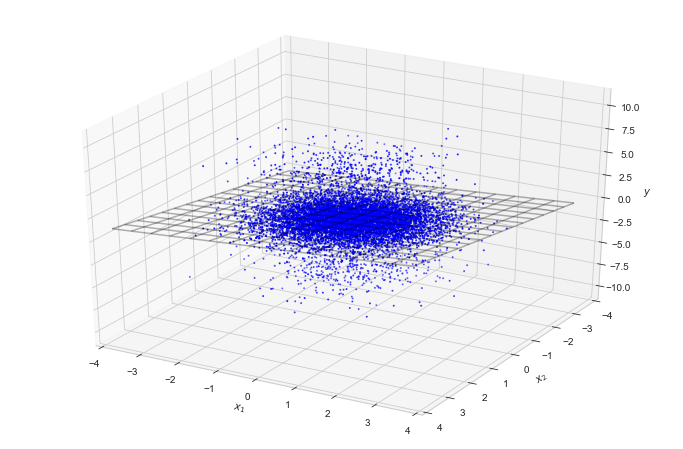

In [385]:
#We create a 3D plot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1, projection='3d') # create a 3d axis in the figure 
ax.scatter(x1,x2,y, c='b', marker='o',s=1) # scatter the data for x_1, x_2 and y

ax.plot_wireframe(xx1, xx2, y_pred_grid, rstride=1, cstride=1, alpha = 0.3, color='Black') # plot the predicted plane

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$y$')

plt.xlim(-4, 4)
plt.ylim(-4, 4)

ax.invert_yaxis() #invert yaxis (x_2) in order to display the data distrubution in relation to the plane


**Question 3:** Esimtate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using a **numerical solver** to solve the ordinary least square problem, shown below, directly. Compare your results with the matrix algebra results.

$$ \min_{\mathbf{\beta}} \sum^N_{i=1} (y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) )^2 $$

In [9]:
#using a numerical solver, linalg.lstsq
Numerical_solver_result=np.linalg.lstsq(X,Y)[0]
print(Numerical_solver_result)

[0.0956821  0.29294299 0.50332771]


In [10]:
#solving using numerical solver 'Nelder-Mead'
t0 = time.time()
def OLS(x):
    Beta_0 = x[0]
    Beta_1 = x[1]
    Beta_2 = x[2]
    return np.sum(np.square(Y-(Beta_0+Beta_1*X1+Beta_2*X2)))

# We set the bounds and start with the given parameter values
Guess =[0.1,0.1,0.1]

# We use the solver to maximize tax revenu given the three parameters
OLS_optimizer = optimize.minimize(OLS, Guess, method='Nelder-Mead')

# We find the optimal parameters 
Beta_0_opt=OLS_optimizer.x[0]
Beta_1_opt=OLS_optimizer.x[1]
Beta_2_opt=OLS_optimizer.x[2]

# We print the parameters and the tax revenu
print(f'Optimal Beta_0 is {Beta_0_opt:.4f}')
print(f'Optimal Beta_1 is {Beta_1_opt:.4f}')
print(f'Optimal Beta_2 is {Beta_2_opt:.4f}')

print(f'{"Nelder-Mead":12s}: {time.time()-t0:.5f} secs')

Optimal Beta_0 is 0.0957
Optimal Beta_1 is 0.2929
Optimal Beta_2 is 0.5034
Nelder-Mead : 0.03364 secs


**Question 4:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **least absolute deviations (LAD)** using a numerical solver to solve the following problem directly: 

$$  \min_{\beta} \sum^N_{i=1} |y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) | $$

where $|z|$ is the absolute value of $z$.

In [11]:
#Now we use a numerical solver for the least absolute deviations (LAD) method
t0 = time.time()
def LAD(x):
    Beta_0 = x[0]
    Beta_1 = x[1]
    Beta_2 = x[2]
    return np.sum(np.abs(y-(Beta_0+Beta_1*x1+Beta_2*x2)))

# We set the bounds and start with the given parameter values
Guess =[0.1,0.1,0.1]

# We use the solver to maximize tax revenu given the three parameters
LAD_optimizer = optimize.minimize(LAD, Guess, method='SLSQP')

# We find the optimal parameters 
Beta_0_opt=LAD_optimizer.x[0]
Beta_1_opt=LAD_optimizer.x[1]
Beta_2_opt=LAD_optimizer.x[2]

# We print the parameters and the tax revenu
print(f'Optimal Beta_0 is {Beta_0_opt:.3f}')
print(f'Optimal Beta_1 is {Beta_1_opt:.3f}')
print(f'Optimal Beta_2 is {Beta_2_opt:.3f}')

print(f'{"SLSQP":12s}: {time.time()-t0:.5f} secs')

Optimal Beta_0 is 0.092
Optimal Beta_1 is 0.307
Optimal Beta_2 is 0.512
SLSQP       : 0.17095 secs


In [12]:
t0 = time.time()
def LAD(x):
    Beta_0 = x[0]
    Beta_1 = x[1]
    Beta_2 = x[2]
    return np.sum(np.abs(y-(Beta_0+Beta_1*X1+Beta_2*X2)))

# We set the bounds and start with the given parameter values
Guess =[0.1,0.1,0.1]

# We use the solver to maximize tax revenu given the three parameters
LAD_optimizer = optimize.minimize(LAD, Guess, method='Nelder-Mead')

# We find the optimal parameters 
Beta_0_opt=LAD_optimizer.x[0]
Beta_1_opt=LAD_optimizer.x[1]
Beta_2_opt=LAD_optimizer.x[2]

# We print the parameters and the tax revenu
print(f'Optimal Beta_0 is {Beta_0_opt:.3f}')
print(f'Optimal Beta_1 is {Beta_1_opt:.3f}')
print(f'Optimal Beta_2 is {Beta_2_opt:.3f}')
print(f'{"Nelder-Mead":12s}: {time.time()-t0:.5f} secs')

Optimal Beta_0 is 0.092
Optimal Beta_1 is 0.307
Optimal Beta_2 is 0.512
Nelder-Mead : 0.03485 secs


**Question 5:** Set $N = 50$. Repeat the estimation using the **OLS** and **LAD** methods $K=5000$ times, drawing a new random sample from the data generating process each time. Compare the estimates from each method using histograms. Which method do you prefer? Explain your choice.

In [13]:
#Now we need to simulate the model using OLS and LAD for:
N=50
K=5000

#We use the OLS method:
Beta_0_OLS = np.empty((K,1))
Beta_1_OLS = np.empty((K,1))
Beta_2_OLS = np.empty((K,1))

for i in range(0,K):
    np.random.seed(i)
    x1,x2,y = DGP(N)
    Y=np.array(y)
    X1=np.array(x1)
    X2=np.array(x2)
    X0=np.ones(shape=Y.shape)
    X=np.column_stack((X0,X1))
    X=np.column_stack((X,X2))
    #FInding coeffs
    coeffs_sim = linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(Y)
    Beta_0_OLS[i] = coeffs_sim[0]
    Beta_1_OLS[i] = coeffs_sim[1]
    Beta_2_OLS[i] = coeffs_sim[2]



In [14]:
N=50
K=5000
#We use the OLS method:
Beta_0_OLS = np.empty((K,1))
Beta_1_OLS = np.empty((K,1))
Beta_2_OLS = np.empty((K,1))

for i in range(0,K):
    np.random.seed(i)
    x1,x2,y = DGP(N)
    Y=np.array(y)
    X1=np.array(x1)
    X2=np.array(x2)
    X0=np.ones(shape=Y.shape)
    X=np.column_stack((X0,X1))
    X=np.column_stack((X,X2))
    def OLS(x):
        Beta_0 = x[0]
        Beta_1 = x[1]
        Beta_2 = x[2]
        return np.sum(np.square(y-(Beta_0+Beta_1*X1+Beta_2*X2)))

    # We set the bounds and start with the given parameter values
    Guess =[0.1,0.1,0.1]

    # We use the solver to maximize tax revenu given the three parameters
    OLS_optimizer = optimize.minimize(OLS, Guess, method='Nelder-Mead')

    #We find the optimal parameters 
    Beta_0_opt=OLS_optimizer.x[0]
    Beta_1_opt=OLS_optimizer.x[1]
    Beta_2_opt=OLS_optimizer.x[2]
    Beta_0_OLS[i] = Beta_0_opt
    Beta_1_OLS[i] = Beta_1_opt
    Beta_2_OLS[i] = Beta_2_opt


In [15]:
N=50
K=5000

#We use the LAD method: LAD LAD LAD
Beta_0_LAD = np.empty((K,1))
Beta_1_LAD = np.empty((K,1))
Beta_2_LAD = np.empty((K,1))

for i in range(0,K):
    np.random.seed(i)
    x1,x2,y = DGP(N)
    Y=np.array(y)
    X1=np.array(x1)
    X2=np.array(x2)
    X0=np.ones(shape=Y.shape)
    X=np.column_stack((X0,X1))
    X=np.column_stack((X,X2))
    t0 = time.time()
    def LAD(x):
        Beta_0 = x[0]
        Beta_1 = x[1]
        Beta_2 = x[2]
        return np.sum(np.abs(y-(Beta_0+Beta_1*X1+Beta_2*X2)))

    # We set the bounds and start with the given parameter values
    Guess =[0.1,0.3,0.5]

    # We use the solver to maximize tax revenu given the three parameters
    LAD_optimizer = optimize.minimize(LAD, Guess, method='SLSQP')

    #We find the optimal parameters 
    Beta_0_opt=LAD_optimizer.x[0]
    Beta_1_opt=LAD_optimizer.x[1]
    Beta_2_opt=LAD_optimizer.x[2]
    Beta_0_LAD[i] = Beta_0_opt
    Beta_1_LAD[i] = Beta_1_opt
    Beta_2_LAD[i] = Beta_2_opt


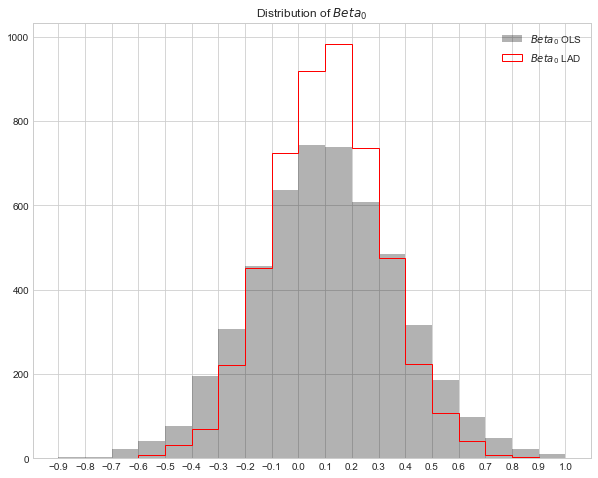

In [16]:
#Histogram for Beta 0
bins = np.arange(-0.9,1.1, step=0.1)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.hist(Beta_0_OLS, color = 'black', bins=bins, histtype='stepfilled', alpha=0.3, label='$Beta_0$ OLS')
ax.hist(Beta_0_LAD, color = 'red', bins=bins, histtype='step',label='$Beta_0$ LAD')
ax.set_title('Distribution of $Beta_0$')
plt.xticks(bins)
ax.legend(loc='upper right')

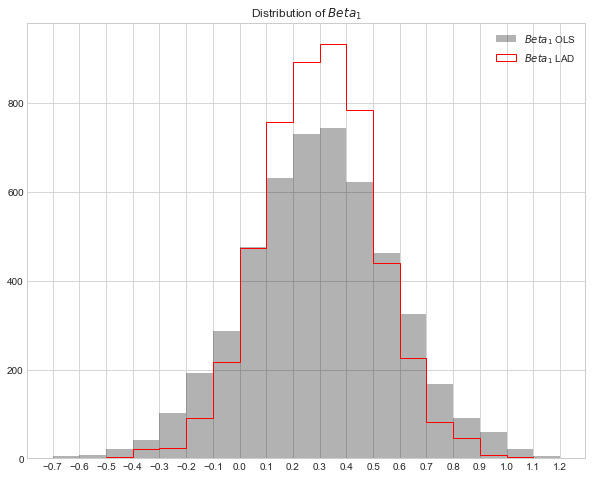

In [17]:
#Histogram for B1
bins = np.arange(-0.7,1.3, step=0.1)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.hist(Beta_1_OLS, color = 'black', bins=bins, histtype='stepfilled', alpha=0.3, label='$Beta_1$ OLS')
ax.hist(Beta_1_LAD, color = 'red', bins=bins, histtype='step',label='$Beta_1$ LAD')
ax.set_title('Distribution of $Beta_1$')
plt.xticks(bins)
ax.legend(loc='upper right')

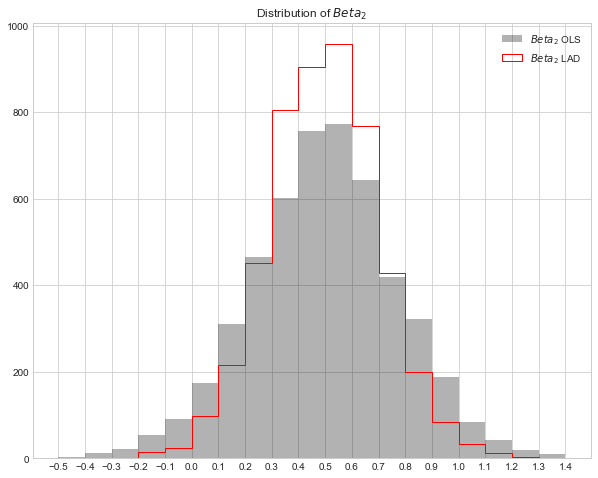

In [18]:
#Histogram for B2
bins = np.arange(-0.5,1.5, step=0.1)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111) 
ax.hist(Beta_2_OLS, color = 'black', bins=bins, histtype='stepfilled', alpha=0.3, label='$Beta_2$ OLS')
ax.hist(Beta_2_LAD, color = 'red', bins=bins, histtype='step',label='$Beta_2$ LAD')
ax.set_title('Distribution of $Beta_2$')
plt.xticks(bins)
ax.legend(loc='upper right')

# Durable purchases

Consider a **household** living in two periods.

In the **second period** it gets utility from **non-durable consumption**, $c$, and **durable consumption**, $d+\chi x$:

$$
\begin{aligned}
v_{2}(m_{2},d)&= \max_{c}\frac{(c^{\alpha}(d+\chi x)^{1-\alpha})^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
x &= m_{2}-c \\
c &\in [0,m_{2}]
\end{aligned}
$$

where 

* $m_2$ is cash-on-hand in the beginning of period 2
* $c$ is non-durable consumption
* $d$ is pre-commited durable consumption
* $x = m_2 - c$ is extra durable consumption
* $\rho > 1$ is the risk aversion coefficient
* $\alpha \in (0,1)$ is the utility weight on non-durable consumption
* $\chi \in (0,1)$ implies that extra durable consumption is *less* valuable than pre-comitted durable consumption
* the second constraint ensures the household *cannot* die in debt

The **value function** $v_2(m_2,d)$ measures the household's value of having $m_2$ at the beginning of period 2 with precomitted durable consumption of $d$. The optimal choice of non-durable consumption is denoted $c^{\ast}(m_2,d)$. The optimal extra durable consumption function is $x^{\ast}(m_2,d) = m_2-c^{\ast}(m_2,d)$.

Define the so-called **end-of-period 1 value function** as:

$$
\begin{aligned}
w(a,d)&\equiv\beta\mathbb{E}_{1}\left[v_2(m_2,d)\right]
\end{aligned}
$$

where 

$$
\begin{aligned}
m_2&= (1+r)a+y \\
y &= \begin{cases}
1-\Delta & \text{with prob. }\frac{1}{3}\\
1 & \text{with prob. }\frac{1}{3}\\
1+\Delta & \text{with prob. }\frac{1}{3}
\end{cases}\\
\end{aligned}
$$

and

* $a$ is assets at the end of period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving)
* $r$ is the return on savings

In the **first period**, the household chooses it's pre-comitted level of durable consumption for the next-period,

$$
\begin{aligned}
v_{1}(m_{1})&=\max_{d} w(a,d)\\&\text{s.t.}&\\
a&= m_{1}-d \\
d&\in [0,m_{1}]\\
\end{aligned}
$$

where $m_1$ is cash-on-hand in period 1. The second constraint ensures the household *cannot* borrow. The **value function** $v_1(m_1)$ measures the household's value of having $m_1$ at the beginning of period 1. The optimal choice of pre-committed durable consumption is denoted $d^{\ast}(m_1)$.

The **parameters** and **grids** for $m_1$, $m_2$ and $d$ should be:

In [252]:
# a. parameters
rho = 2
alpha = 0.8
beta = 0.96
r = 0.04
Delta = 0.25

# b. grids
m1_vec = np.linspace(1e-8,10,100)
m2_vec = np.linspace(1e-8,10,100)
d_vec = np.linspace(1e-8,5,100)

In [253]:
# Additionally we received information on the parameter chi, which should be set to 0.9:
chi=0.9

In [176]:
# Defining value function 2 and substituting the constraint into the value function
#def v2(c,rho,d,chi,m2,alpha):
#    return (c**alpha*(d+chi**(m2-c))**(1-alpha))**(1-rho)/(1-rho)

In [302]:
# Defining value function for period 2
def v2(c,d,alpha,rho,m2,chi):
    return (c**alpha*(d+chi*(m2-c))*(1-alpha))**(1-rho)/(1-rho) #Have substituted the constraint into the function

# Defining end of period 1 value function, w
def w(d,beta,r,m1,Delta,v2_interp):
   
    # a. w value if low income
    m2_low = (1+r)*(m1-d) + 1-Delta  #also substituting in v1's constraint a = m1-d
    v2_low = v2_interp([m2_low,d])[0] 

    # b. w value if mid income
    m2_mid = (1+r)*(m1-d) + 1        #also substituting in v1's constraint a = m1-d
    v2_mid = v2_interp([m2_mid,d])[0] 
    
    # c. w value if high income
    m2_high = (1+r)*(m1-d) + 1+Delta #also substituting in v1's constraint a = m1-d
    v2_high = v2_interp([m2_high,d])[0] 

    # d. expected w value
    return ((1/3)*v2_low + (1/3)*v2_mid + (1/3)*v2_high)*beta
    
    # e. final w
    #return w

# defining v1
def v1(d,beta,r,m1,Delta,v2_interp):
    # total value
    v1 = w
    return v1



**Question 1:** Find and plot the functions $v_{2}(m_{2},d)$, $c^{\ast}(m_2,d)$, and $x^{\ast}(m_2,d)$. Comment.

In [303]:
def solve_period_2(alpha,rho,chi,Delta):
   #Grids
    m2_vec = np.linspace(1e-8,10,100)
    d_vec = np.linspace(1e-8,5,100)
    v2_grid = np.empty((100,100))
    c_grid = np.empty((100,100))
    x_grid = np.empty((100,100))
    
    #Loop
    for i,m2 in enumerate(m2_vec):
        for j,d in enumerate(d_vec):

            #Objective
            obj = lambda c: -v2(c,d,alpha,rho,m2,chi)

            #initial value
            x0 = m2/2

            #Optimize
            result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m2])

            # iv. save
            v2_grid[i,j] = -result.fun
            c_grid[i,j] = result.x
            x_grid[i,j] = m2 - result.x

    return m2_vec,d_vec,v2_grid,c_grid,x_grid


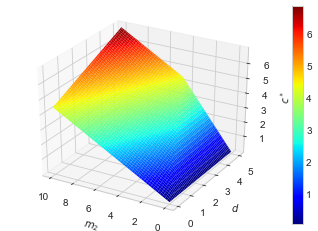

In [304]:
# a. solve
m2_vec,d_vec,v2_grid,c_grid,x_grid = solve_period_2(alpha,rho,chi,Delta)

# b. grids
m2_grid,d_grid = np.meshgrid(m2_vec,d_vec,indexing='ij')

# c. main
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,c_grid,cmap=cm.jet)

# d. add labels
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$c^*$')

# e. invert xaxis
ax.invert_xaxis()

# f. add colorbar
fig.colorbar(cs);

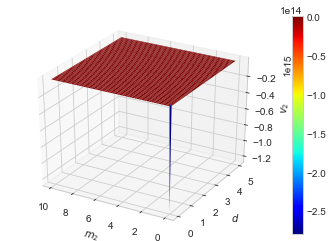

In [305]:
m2_vec,d_vec,v2_grid,c_grid,x_grid = solve_period_2(alpha,rho,chi,Delta)

# b. grids
m2_grid,d_grid = np.meshgrid(m2_vec,d_vec,indexing='ij')

# c. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,v2_grid,cmap=cm.jet)

# d. add labels
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$v_2$')

# e. invert xaxis
ax.invert_xaxis()

# f. add colorbar
fig.colorbar(cs);

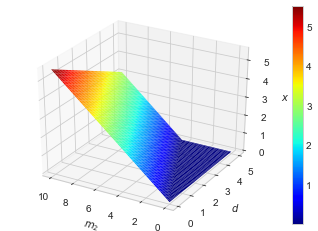

In [306]:
m2_vec,d_vec,v2_grid,c_grid,x_grid = solve_period_2(alpha,rho,chi,Delta)

# b. grids
m2_grid,d_grid = np.meshgrid(m2_vec,d_vec,indexing='ij')

# c. main
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,x_grid,cmap=cm.jet)

# d. add labels
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$x$')

# e. invert xaxis
ax.invert_xaxis()

# f. add colorbar
fig.colorbar(cs);

In [313]:
def solve_period_1(alpha,rho,beta,r,Delta,v2_interp):
    # a. grids
    m1_vec = np.linspace(1e-8,10,100)
    v1_vec = np.empty(100)
    d_vec = np.empty(100)
    
    #Loop
    for i,m1 in enumerate(m1_vec):

        #Obejctive
        #c = 
        obj = lambda d: -w(d,beta,r,m1,Delta,v2_interp)
        #obj = lambda d: -w(d,beta,r,m1,Delta,v2_interp)

        #initial value
        x0 = m1*1/2
        #x0 = m1*1/2

        #Bounds
        #bound = (1e-8,m1-1e-8)
        #bounds = (bound)
        #ineq_con = {'type': 'ineq', 'fun': lambda x: m1-d} 

        #Optimize
        #result = optimize.minimize(obj,x0, method='SLSQP',
        #                          bounds=bounds,
        #                          constraints=[ineq_con])
        
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m1])

        #result = optimize.minimize(obj,[x0], method='L-BFGS-B',bounds=([1e-8,m1],))

        # iv. save
        v1_vec[i] = -result.fun
        d_vec[i] = result.x

    return m1_vec,v1_vec,d_vec

In [315]:
#v2_interp = interpolate.RegularGridInterpolator([m2_vec,d_vec],v2_grid,bounds_error=False,fill_value=None)
#c_interp = interpolate.RegularGridInterpolator([m2_vec,d_vec],c_grid,bounds_error=False,fill_value=None)

m1_vec,v1_vec,d_vec = solve_period_1(alpha,rho,beta,r,Delta,v2_interp)

# d. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,v1_vec,label='v')
#ax.plot(m1_vec,d_vec,label='d')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')
#ax.set_xlim([0,100])
#ax.set_ylim([0,100]);

ValueError: The points in dimension 1 must be strictly ascending

Text(0.5,0,'$m_1$')

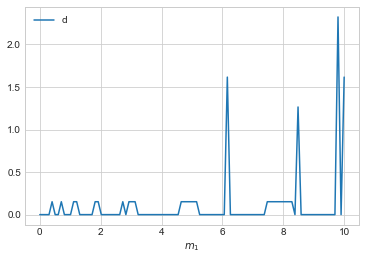

In [309]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(m1_vec,d_vec,label='d')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')

In [67]:
def solve_period_2(alpha,rho,chi,Delta):

    # a. grids (from before)
    m2_vec = np.linspace(1e-8,10,100)
    v2_vec = np.empty((100,100))
    c_vec = np.empty((100,100))

    # b. solve for each m2 in grid

    for i,m2 in enumerate(m2_vec):
    
            # i. objective
            obj = lambda c: -v2(c,alpha,d,rho,m2,chi)

            # ii. initial value (consume half)
            x0 = m2/2

            # iii. optimizer
            result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m1])

            # iv. save
            v2_vec[i] = -result.fun
            c_vec[i] = result.x
        
    return m2_vec,v2_vec,c_vecdef solve_period_2(alpha,rho,chi,Delta):

    # a. grids (from before)
    m2_vec = np.linspace(1e-8,10,100)
    v2_vec = np.empty((100,100))
    c_vec = np.empty((100,100))

    # b. solve for each m2 in grid

    for i,m2 in enumerate(m2_vec):
    
            # i. objective
            obj = lambda c: -v2(c,alpha,d,rho,m2,chi)

            # ii. initial value (consume half)
            x0 = m2/2

            # iii. optimizer
            result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m2])

            # iv. save
            v2_vec[i] = -result.fun
            c_vec[i] = result.x
        
    return m2_vec,v2_vec,c_vec

SyntaxError: invalid syntax (<ipython-input-67-9bf1acdecf78>, line 25)

In [23]:
def solve_period_2(rho, alpha, beta, r, Delta):

    # a. grids
    m2_vec = np.linspace(1e-8,10,100)
    d_vec = np.linspace(1e-8,5,100)
    c_vec = np.empty(100)
    v2_vec = np.empty(100)
    x_vec = np.empty(100)


    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):

        # i. objective
        obj = lambda w: -v2(c,rho,d,chi,m2,alpha)

        # ii. initial value (consume half)
        x0 = m2/2

        # iii. optimizer
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m2])

        # Finding c
        c_vec[i] = 

        # Finding x
        x_vec[i] = m2_vec[i]-c_vec[i]


        # iv. save
        v2_vec[i] = -result.fun
        d_vec[i] = result.x
        
    return m2_vec,v2_vec,c_vec,x_vec

# solve
m2_vec,v2_vec,c_vec,x_vec = solve_period_2(rho, alpha, beta, r, Delta)

# illustration
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(m2_vec,d_vec)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d_2$')
ax.set_title('consumption function in period 2')

ax = fig.add_subplot(1,2,2)
ax.plot(m2_vec,m1_vec)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$m_1$')
ax.set_title('value function in period 2')
ax.set_ylim([-40,1]);

SyntaxError: invalid syntax (<ipython-input-23-45d0f50e2bf4>, line 24)

**Question 2:** Find and plot the functions $v_{1}(m_{1})$ and $d^{\ast}(m_1)$. Comment.

**Hint:** For interpolation of $v_2(m_2,d)$ consider using `interpolate.RegularGridInterpolator([GRID-VECTOR1,GRID-VECTOR2],VALUE-MATRIX,bounds_error=False,fill_value=None)`.

Next, consider an **extension** of the model, where there is also a **period 0**. In this period, the household makes a choice whether to stick with the level of durables it has, $z = 0$, or adjust its stock of durables, $z = 1$. If adjusting, the household loses a part of the value of its durable stock; more specificaly it incurs a proportional loss of $\Lambda \in (0,1)$.

Mathematically, the **household problem in period 0** is:

$$
\begin{aligned}
v_{0}(m_{0},d_{0}) &= \max_{z\in\{0,1\}} \begin{cases}
w(m_{0},d_{0}) & \text{if } z = 0\\
v_1(m_0+(1-\Lambda) d_{0}) & \text{if } z = 1\\
\end{cases}\\
\end{aligned}
$$

The **parameters** and **grids** for $m_0$ and $d_0$ should be:

In [24]:
Lambda = 0.2
m0_vec = np.linspace(1e-8,6,100)
d0_vec = np.linspace(1e-8,3,100)

**Question 3:** For which values of $m_0$ and  $d_0$ is the optimal choice not to adjust, i.e. $z = 0$? Show this in a plot. Give an interpretion of your results.

# Gradient descent

Let $\boldsymbol{x} = \left[\begin{array}{c}
x_1 \\
x_2\\
\end{array}\right]$ be a two-dimensional vector. Consider the following algorithm:

**Algorithm:** `gradient_descent()`

**Goal:** Minimize the function $f(\boldsymbol{x})$.

1. Choose a tolerance $\epsilon>0$, a scale factor $ \Theta > 0$, and a small number $\Delta > 0$
2. Guess on $\boldsymbol{x}_0$ and set $n=1$
3. Compute a numerical approximation of the jacobian for $f$ by

    $$
    \nabla f(\boldsymbol{x}_{n-1}) \approx \frac{1}{\Delta}\left[\begin{array}{c}
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    \Delta\\
    0
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})\\
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    0\\
    \Delta
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})
    \end{array}\right]
    $$

4. Stop if the maximum element in $|\nabla f(\boldsymbol{x}_{n-1})|$ is less than $\epsilon$
5. Set $\theta = \Theta$ 
6. Compute $f^{\theta}_{n} = f(\boldsymbol{x}_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1}))$
7. If $f^{\theta}_{n} < f(\boldsymbol{x}_{n-1})$ continue to step 9
8. Set $\theta = \frac{\theta}{2}$ and return to step 6     
9. Set $x_{n} = x_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1})$
10. Set $n = n + 1$ and return to step 3

**Question:** Implement the algorithm above such that the code below can run.

**Optimizer function:**

In [25]:
def gradient_descent(f,x0,epsilon=1e-6,Theta=0.1,Delta=1e-8,max_iter=10_000):
    # step 1: initialize
    #Epsilon,Theta,Delta
    # step 2: Guess on x0 and set n=1
    x = x0
    n = 1

    # Step 3: Compute a numerical approx
    f(x)=x0

    # step 3-9: iteration
    while n < max_iter:
        
        x_prev = x
        fx_prev = fx
        
        # step 2: evaluate gradient and hessian
        jacx = jac(x_prev)
        hessx = hess(x_prev)
        
        # step 3: update x
        inv_hessx = linalg.inv(hessx)        
        x = x_prev - inv_hessx@jacx
     
        # step 4: check convergence
        fx = f(x)
        if abs(fx-fx_prev) < tol:
            break
            
        # step 5: increment n
        n += 1
        
    return x,n

In [27]:
def gradient_descent2(f,x0,epsilon=1e-6,Theta=0.1,Delta=1e-8,max_iter=10_000):
    # step 1: initialize
    x = x0
    fx = f(x0)
    n = 1
    
    # step 2-5: iteration
    while n < max_iter:
        
        x_prev = x
        fx_prev = fx
        
        # step 2: evaluate gradient and hessian
        jacx = jac(x_prev)
        hessx = hess(x_prev)
        
        # step 3: update x
        inv_hessx = linalg.inv(hessx)        
        x = x_prev - inv_hessx@jacx
     
        # step 4: check convergence
        fx = f(x)
        if abs(fx-fx_prev) < tol:
            break
            
        # step 5: increment n
        n += 1
        
    return x,n

**Test case:**

In [28]:
def rosen(x):
    return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2

x0 = np.array([1.1,1.1])
try:
    x,it = gradient_descent(rosen,x0)
    print(f'minimum found at ({x[0]:.4f},{x[1]:.4f}) after {it} iterations')
    assert np.allclose(x,[1,1])
except:
    print('not implemented yet')

not implemented yet
